In [32]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

(938, 473, 3)


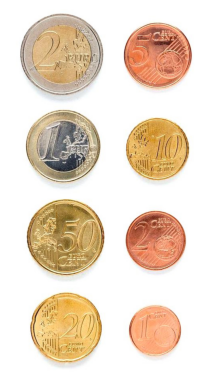

In [33]:
#Carga imagen ejemplo con monedas
img = cv2.imread('Monedas.jpg') 
print(img.shape)
#Recordar que OpenCV lee las imágenes en BGR, por lo que convertimos para visualizr a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.axis("off")
plt.imshow(img_rgb) 
plt.show()

Text(0.5, 1.0, 'FIJO invertida')

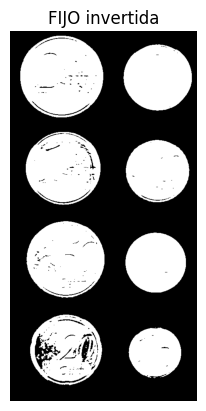

In [34]:
#Convertimos la imagen a escala de grises
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Aplicar un blur para reducir ruido
img_blur = cv2.GaussianBlur(img_gris, (5,5), 0)
# Luego aplicar Otsu
th, img_th1 = cv2.threshold(img_blur,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.axis("off")
plt.imshow(img_th1,cmap='gray') 
plt.title('FIJO invertida')


Text(0.5, 1.0, 'Externos')

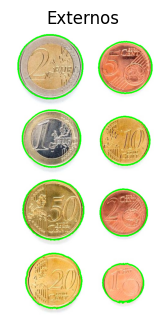

In [35]:
# Comenzamos la detección de contornos
#Obtiene únicamente los contornos externos
contornos, hierarchy1 = cv2.findContours(img_th1, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

#Dibuja sobre la imagen de entrada sólo contornos externos
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
cv2.drawContours(img_rgb, contornos, -1, (0,255,0), 3)

plt.subplot(132)
plt.axis("off")
plt.imshow(img_rgb) 
plt.title('Externos')

In [37]:
# --- Tabla de diámetros de monedas en mm ---
monedas_mm = {
    "1 centimo": 16.25,
    "2 centimos": 18.75,
    "5 centimos": 21.25,
    "10 centimos": 19.75,
    "20 centimos": 22.25,
    "50 centimos": 24.25,
    "1 euro": 23.25,
    "2 euros": 25.75,
}

monedas_valor = {
    "1 centimo": 0.01, "2 centimos": 0.02, "5 centimos": 0.05,
    "10 centimos": 0.10, "20 centimos": 0.20, "50 centimos": 0.50,
    "1 euro": 1.00, "2 euros": 2.00
}

# Guardar círculos detectados [(x, y, radio)]
circulos = []
for c in contornos:
    area = cv2.contourArea(c)
    perimetro = cv2.arcLength(c, True)
    circularidad = 4 * np.pi * area / (perimetro**2 + 1e-5)
    if circularidad < 0.5:
        continue
    (x, y), r = cv2.minEnclosingCircle(c)
    circulos.append((int(x), int(y), r))

# --- Variables globales ---
escala = None  # px/mm
referencia_seleccionada = False

# --- Función callback para ratón ---
def click_event(event, x, y, flags, param):
    global escala, referencia_seleccionada
    if event == cv2.EVENT_LBUTTONDOWN:
        # Buscar círculo más cercano al clic
        for (cx, cy, r) in circulos:
            if (x - cx) ** 2 + (y - cy) ** 2 <= r ** 2:
                # Usar este círculo como referencia
                radio_ref_pix = r
                diametro_ref_mm = 23.25  # asumimos que es 1 €
                escala = (2 * radio_ref_pix) / diametro_ref_mm
                referencia_seleccionada = True
                print(f"Moneda de referencia seleccionada en ({cx},{cy}), radio {r:.2f}px")
                break

cv2.namedWindow("Monedas")
cv2.setMouseCallback("Monedas", click_event)

while True:
    display = img.copy()

    # Dibujar contornos
    for (cx, cy, r) in circulos:
        cv2.circle(display, (cx, cy), int(r), (0, 255, 0), 2)
        cv2.circle(display, (cx, cy), 2, (0, 0, 255), -1)

    if referencia_seleccionada and escala is not None:
        conteo = {}
        valor_total = 0.0

        for (cx, cy, r) in circulos:
            diametro_mm = (2 * r) / escala

            # Clasificar moneda: la más cercana en diámetro
            mejor_moneda = min(monedas_mm.keys(),
                               key=lambda m: abs(monedas_mm[m] - diametro_mm))

            # Acumular conteo y valor
            conteo[mejor_moneda] = conteo.get(mejor_moneda, 0) + 1
            valor_total += monedas_valor[mejor_moneda]

            # Etiquetar en imagen
            cv2.putText(display, mejor_moneda, (cx - 40, cy),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.3, (255, 0, 0), 2)

        cv2.putText(display, f"Total: {valor_total:.2f} euros",
                    (30, 30), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 255), 3)

    cv2.imshow("Monedas", display)

    if cv2.waitKey(1) & 0xFF == 27:  # ESC para salir
        break

cv2.destroyAllWindows()
cv2.waitKey(1)

Moneda de referencia seleccionada en (366,814), radio 66.31px


-1